Importing the required modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('fivethirtyeight')

Reading the pickled dataframe

In [2]:
df = pd.read_pickle('./WC2018_preprocessed.pkl')
df.head()

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,timestamp,outcome_name,outcome_id,body_part_name,...,pack_density,shot_player,home_or_away,key_pass_type,key_pass_pattern,isCross,isCutback,preceding_event_player,preceding_event_team,statsbomb_xg
0,97.0,53.0,26.4,28.600699,24.698178,15.1,2020-04-18 00:04:17.267,Off T,98,Right Foot,...,2,Mile Jedinak,home,None,None,False,False,Mile Jedinak,Australia,0.032260
1,95.0,46.0,25.7,26.925824,25.079872,17.2,2020-04-18 00:11:27.587,Blocked,96,Left Foot,...,3,Tom RogiÄ‡,home,Ground Pass,From Throw In,False,False,Tom RogiÄ‡,Australia,0.049563
2,104.0,53.0,20.6,23.345235,18.357560,17.4,2020-04-18 00:17:14.547,Goal,97,Right Foot,...,2,AndrÃ© MartÃ­n Carrillo DÃ­az,away,High Pass,Regular Play,False,False,AndrÃ© MartÃ­n Carrillo DÃ­az,Peru,0.035208
3,112.0,42.0,8.2,10.000000,8.246211,50.9,2020-04-18 00:20:00.707,Wayward,101,Head,...,2,Mathew Leckie,home,High Pass,From Throw In,True,False,Mathew Leckie,Australia,0.129688
4,109.0,37.0,11.4,11.045361,13.038405,37.7,2020-04-18 00:24:07.787,Saved,100,Head,...,1,JosÃ© Paolo Guerrero GonzÃ¡lez,away,High Pass,From Free Kick,False,False,JosÃ© Paolo Guerrero GonzÃ¡lez,Peru,0.036955


**Modifying the dataframe based on the exploration**

Two columns are added 'isGoal' and 'isGoalBool' to keep track of shots that result in goals for plotting and other calculations.

In [3]:
isGoal=[]
isGoalBool = []
for outcome in df['outcome_name'].values:
    if outcome=='Goal':
        isGoal.append('Goal')
        isGoalBool.append(1)
    else:
        isGoal.append('Not Goal')
        isGoalBool.append(0)

In [4]:
df['isGoal']=isGoal
df['isGoalBool']=isGoalBool

We then merge the features - key_pass_type,isCross and isCutback into 1 feature : cross_cutback_forward. This makes it easier to encode as a categorical feature later.

In [5]:
cross_cutback_forward = []
for index, rows in df.iterrows():
    if rows['key_pass_type']=='None':
        cross_cutback_forward.append('none')
    else:
        if (rows['isCross']==False) and (rows['isCutback']==False):
            cross_cutback_forward.append('forward')
        elif rows['isCross']==True:
            cross_cutback_forward.append('cross')
        elif rows['isCutback']==True:
            cross_cutback_forward.append('cutback')

In [6]:
df['cross_cutback_forward']=cross_cutback_forward
df['cross_cutback_forward'].value_counts()

forward    863
none       514
cross      310
cutback      6
Name: cross_cutback_forward, dtype: int64

Since the cutbacks are very less and do not result in goal, we will be dropping the rows with key pass type 'cutback'.

In [7]:
df=df[df['cross_cutback_forward']!='cutback']
df['cross_cutback_forward'].value_counts()

forward    863
none       514
cross      310
Name: cross_cutback_forward, dtype: int64

Modifying the key_pass_pattern feature similarly

In [8]:
df['key_pass_pattern'].value_counts()

Regular Play      517
None              514
From Throw In     201
From Corner       198
From Free Kick    160
From Counter       44
From Goal Kick     30
From Keeper        14
From Kick Off       7
Other               2
Name: key_pass_pattern, dtype: int64

Because of their sample sizes, we group the samples into 'Regular Play', 'Non Regular Play' and 'None'

In [9]:
key_pass_pattern_list =[]
for index, rows in df.iterrows():
    if rows['key_pass_pattern']=='None':
        key_pass_pattern_list.append('none')
    else:
        if (rows['key_pass_pattern']=='Regular Play'):
            key_pass_pattern_list.append('Regular Play')
        else:
            key_pass_pattern_list.append('Non Regular Play')

In [10]:
df['key_pass_pattern']=key_pass_pattern_list
df['key_pass_pattern'].value_counts()

Non Regular Play    656
Regular Play        517
none                514
Name: key_pass_pattern, dtype: int64

Now let us look at the 'type_name' variable

In [11]:
df['type_name'].value_counts()

Open Play    1543
Free Kick      80
Penalty        64
Name: type_name, dtype: int64

Looking at the sample size of this variable, it makes sense to ignore the Freekick and Penalty shoots and restrict the model to look at shots which are not direct shots.

In [12]:
df = df[df.type_name=='Open Play']
df.type_name.value_counts()

Open Play    1543
Name: type_name, dtype: int64

Our exploration also showed that the time of shot and shot being taken by home or away team did not matter. So it makes sense to drop these columns.

In [13]:
df=df.drop(['timestamp','home_or_away'],axis=1)
df.columns

Index(['shot_x', 'shot_y', 'shot_distance', 'shot_a', 'shot_b', 'shot_angle',
       'outcome_name', 'outcome_id', 'body_part_name', 'body_part_id',
       'technique_name', 'technique_id', 'type_name', 'type_id', 'first_time',
       'preceding_event', 'pack_density', 'shot_player', 'key_pass_type',
       'key_pass_pattern', 'isCross', 'isCutback', 'preceding_event_player',
       'preceding_event_team', 'statsbomb_xg', 'isGoal', 'isGoalBool',
       'cross_cutback_forward'],
      dtype='object')

**Removing other redundant features**


In [14]:
df=df.drop(['shot_x','shot_y','shot_a','shot_b','outcome_name','body_part_id','outcome_id','technique_name','technique_id','type_name','type_id','preceding_event','shot_player','preceding_event_player','preceding_event_team','isCutback','isCross','isGoal'],axis=1)
df.columns

Index(['shot_distance', 'shot_angle', 'body_part_name', 'first_time',
       'pack_density', 'key_pass_type', 'key_pass_pattern', 'statsbomb_xg',
       'isGoalBool', 'cross_cutback_forward'],
      dtype='object')

Modify the 'first_time' feature

In [15]:
first_time_list =[]
for index, rows in df.iterrows():
    if rows['first_time']==True:
        first_time_list.append('first_time')
    else:
        first_time_list.append('carry')
df['first_time_or_carry']=first_time_list
df['first_time_or_carry'].value_counts()

carry         1189
first_time     354
Name: first_time_or_carry, dtype: int64

In [16]:
df=df.drop(['first_time'],axis=1)
df.columns

Index(['shot_distance', 'shot_angle', 'body_part_name', 'pack_density',
       'key_pass_type', 'key_pass_pattern', 'statsbomb_xg', 'isGoalBool',
       'cross_cutback_forward', 'first_time_or_carry'],
      dtype='object')

Finally, let's modify the 'body_part_name' feature

In [17]:
body_part_list=[]
for index, rows in df.iterrows():
    if (rows['body_part_name']=='Right Foot') or (rows['body_part_name']=='Left Foot'):
        body_part_list.append('Foot')
    elif (rows['body_part_name']=='Head'):
        body_part_list.append('Head')
    else:
        body_part_list.append('Other')

In [18]:
df['body_part_name']=body_part_list
df.body_part_name.value_counts()

Foot     1219
Head      310
Other      14
Name: body_part_name, dtype: int64

Since the shots taken by body parts other than foot and head are very less. Let's drop these few shots.

In [19]:
df=df[df.body_part_name != 'Other']
df.body_part_name.value_counts()

Foot    1219
Head     310
Name: body_part_name, dtype: int64

In [20]:
df.head()

,shot_distance,shot_angle,body_part_name,pack_density,key_pass_type,key_pass_pattern,statsbomb_xg,isGoalBool,cross_cutback_forward,first_time_or_carry
0,26.4,15.1,Foot,2,None,none,0.032260,0,none,first_time
1,25.7,17.2,Foot,3,Ground Pass,Non Regular Play,0.049563,0,forward,carry
2,20.6,17.4,Foot,2,High Pass,Regular Play,0.035208,1,forward,first_time
3,8.2,50.9,Head,2,High Pass,Non Regular Play,0.129688,0,cross,carry
4,11.4,37.7,Head,1,High Pass,Non Regular Play,0.036955,0,forward,carry


Checking for any missing values before moving on to any scaling or encoding.

In [21]:
df.isna().any()

shot_distance            False
shot_angle               False
body_part_name           False
pack_density             False
key_pass_type            False
key_pass_pattern         False
statsbomb_xg             False
isGoalBool               False
cross_cutback_forward    False
first_time_or_carry      False
dtype: bool

**Creating a pipeline for encoding and scaling**

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [23]:
#re-arranging column order
df =df[['shot_distance', 'shot_angle', 'body_part_name', 'pack_density',
       'key_pass_type', 'key_pass_pattern','cross_cutback_forward', 'first_time_or_carry','isGoalBool','statsbomb_xg']]

In [24]:
X = df.loc[:,df.columns!='isGoalBool']
y=df['isGoalBool']

In [25]:
X.head()

,shot_distance,shot_angle,body_part_name,pack_density,key_pass_type,key_pass_pattern,cross_cutback_forward,first_time_or_carry,statsbomb_xg
0,26.4,15.1,Foot,2,None,none,none,first_time,0.032260
1,25.7,17.2,Foot,3,Ground Pass,Non Regular Play,forward,carry,0.049563
2,20.6,17.4,Foot,2,High Pass,Regular Play,forward,first_time,0.035208
3,8.2,50.9,Head,2,High Pass,Non Regular Play,cross,carry,0.129688
4,11.4,37.7,Head,1,High Pass,Non Regular Play,forward,carry,0.036955


In [26]:
y[:5]

0    0
1    0
2    1
3    0
4    0
Name: isGoalBool, dtype: int64

Since there are numerical and categorical columns. We use the ColumnTransformer to encode categorical columns and scale numerical columns.

In [27]:
from sklearn.compose import ColumnTransformer

In [28]:
#intializing scaler and encoder
ohe=OneHotEncoder(sparse=False)
ss = StandardScaler()

#selecting categorical and numerical columns
cat_columns = ['body_part_name','key_pass_type','key_pass_pattern','cross_cutback_forward','first_time_or_carry']
num_columns = ['shot_distance','shot_angle','pack_density']

transformers = [('cat',ohe,cat_columns),('num',ss,num_columns)]

In [29]:
#using the passthrough option because we don't want to transform the statsbomb_xg column 
ct = ColumnTransformer(transformers,remainder='passthrough') 
X_t = ct.fit_transform(X)

**Splitting our data into training and test sets**

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_t,y, test_size=0.3, stratify=y)

Since 'statsbomb_xg' is not a predictor feature, we can extract it and keep it aside for comparisons later. But we will delete it from our train and test feature matrices

In [32]:
train_statsbomb = X_train[:,-1]
test_statsbomb = X_test[:,-1]
X_train = np.delete(X_train,-1,axis=1)
X_test = np.delete(X_test,-1,axis=1)

**Try out different models**

- **Logistic Regression**

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
#initializing a default logistic regression model and fitting to our training data
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
y_train_pred = log_reg.predict(X_train)
y_train_proba = log_reg.predict_proba(X_train)

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

In [37]:
def plot_roc_curve(y,y_model_proba,y_statsbomb_proba,model_label):
    fpr,tpr,thresholds = roc_curve(y,y_model_proba[:,1]) # extracting probability for positive class
    fpr_sb,tpr_sb,thresholds_sb = roc_curve(y,y_statsbomb_proba) # statsbomb_xg values
    plt.plot(fpr,tpr,label=model_label)
    plt.plot(fpr_sb,tpr_sb,label='statsbomb')
    plt.plot([0,1],[0,1])
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');

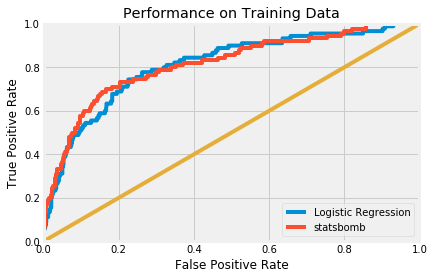

In [38]:
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Logistic Regression')
plt.title('Performance on Training Data');

In [41]:
print('The auc score for the Logistic Regression model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

The auc score for the Logistic Regression model on the training data is 0.81
The auc score for the Statsbomb model on the training data is 0.81


Logistic regression compares very well to the StatsBomb model on the training data. Now let us look at its performance on the test data.

The auc score for the Logistic Regression model on the test data is 0.75
The auc score for the Statsbomb model on the test data is 0.77


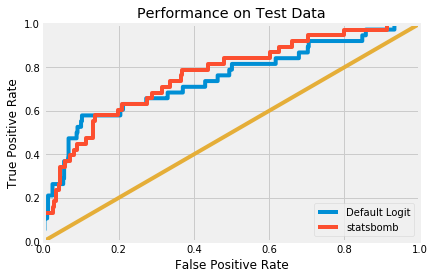

In [42]:

y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)

plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Default Logit')
plt.title('Performance on Test Data');

print('The auc score for the Logistic Regression model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),2)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

The performance on the test data is still pretty good. Let us do some hyper parameter tuning to try and improve the performance 

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10,100]}
gs_logit = GridSearchCV(LogisticRegression(),param_grid,scoring='roc_auc',cv=5)
gs_logit.fit(X_train,y_train)
gs_logit.best_params_

{'C': 0.1}

Let's extract the best estimator and calculate the AUC score on the test data

In [45]:
logit_best = gs_logit.best_estimator_
logit_best.fit(X_train,y_train)


y_test_proba = logit_best.predict_proba(X_test)
print('The auc score for the Logistic Regression model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

The auc score for the Logistic Regression model on the test data is 0.751
The auc score for the Statsbomb model on the test data is 0.77


The improvement is negligible but let's carry forward this estimator and look at what our precision recall curves and confusion matrix looks like

In [50]:
precisions,recalls,thresholds = precision_recall_curve(y_train,y_train_proba[:,1])

def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    ''' From Hands On Machine Learning with Scikit-Learn and TensorFlow by 
    Aurelien Geron
    '''
    plt.plot(thresholds,precisions[:-1],label='Precision')
    plt.plot(thresholds,recalls[:-1],label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylim([0,1])

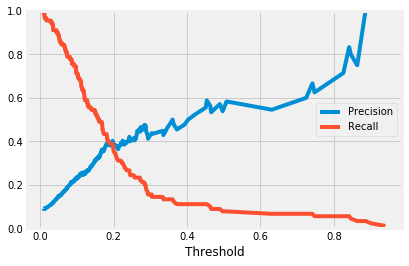

In [51]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

If we use a theshold of 0.5, we will get a low recall and high precision. We ideally, want to get a high recall as we want to classify all goals correctly. Let's use a threshold of 0.1 to compute the confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
predict_new = np.where(y_test_proba[:,1]>0.1,1,0)
print(confusion_matrix(y_test,predict_new))

[[342  79]
 [ 16  22]]


Because of precision-recall tradeoff, since we reduced the threshold to get high recall, it hurt our precision. But this is overall an acceptable model. Since the recall and precision scores are a function of the threshold, for model evaluation going forward, we will stick to the auc score

In [52]:
#saving best logistic regression model
from joblib import dump
dump(logit_best,'best_logit.joblib')

['best_logit.joblib']

**Gradient Boost Classifier**

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
gb_clf = GradientBoostingClassifier() #default GradientBoostingClassifier
gb_clf.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

The auc score for the Default GradientBoost model on the training data is 0.966
The auc score for the Statsbomb model on the training data is 0.81


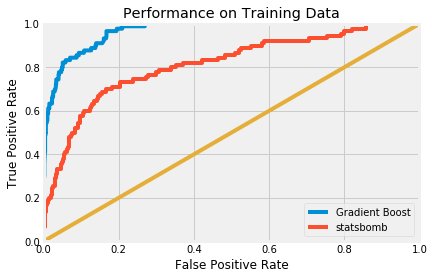

In [55]:

y_train_proba = gb_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='Gradient Boost')
plt.title('Performance on Training Data');

print('The auc score for the Default GradientBoost model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

The default GradientBoost model also works very well on the training data. Let's check it's performance on test data


The auc score for the GradientBoost model on the test data is 0.683
The auc score for the Statsbomb model on the test data is 0.77


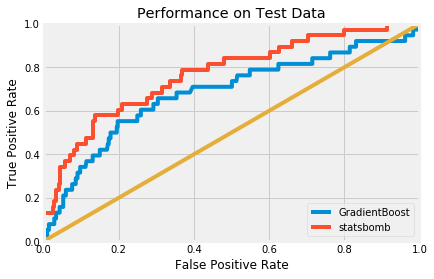

In [56]:
y_test_proba = gb_clf.predict_proba(X_test)
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='GradientBoost')
plt.title('Performance on Test Data');

print('The auc score for the GradientBoost model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

Let's do some grid searching to optimize the performance of this model

In [57]:
param_grid={'max_depth':[1,2,3],'n_estimators':[10,25,50,75,100,250,500,1000],'learning_rate':[0.1,0.25,0.5,1.0],'subsample':[0.1,0.25,0.5,1.0],
           'warm_start':[True,False]}
gs_gb = GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5,scoring='roc_auc')
gs_gb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [58]:
gs_gb.best_params_

{'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 250,
 'subsample': 1.0,
 'warm_start': True}

In [59]:
best_gb = gs_gb.best_estimator_
best_gb.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)

In [60]:
y_test_proba = best_gb.predict_proba(X_test)

The auc score for the Best GradientBoost model on the test data is 0.733
The auc score for the Statsbomb model on the test data is 0.77


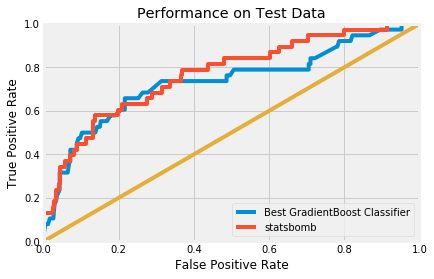

In [61]:
from sklearn.metrics import roc_auc_score
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best GradientBoost Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best GradientBoost model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

In [62]:
dump(best_gb,'best_gradboost.joblib')


['best_gradboost.joblib']

**xGBoost**

In [63]:
import xgboost as xgb

In [64]:
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

The auc score for the Default xgboost model on the training data is 0.999
The auc score for the Statsbomb model on the training data is 0.81


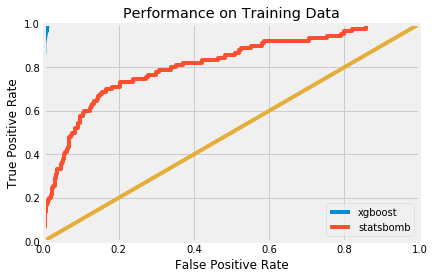

In [65]:

y_train_proba = xg_clf.predict_proba(X_train)
plot_roc_curve(y_train,y_train_proba,train_statsbomb,model_label='xgboost')
plt.title('Performance on Training Data');

print('The auc score for the Default xgboost model on the training data is {}'.format(round(roc_auc_score(y_train,y_train_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the training data is {}'.format(round(roc_auc_score(y_train,train_statsbomb),2)))

In [66]:
param_grid = {'n_estimators':[50,100,250,500],'learning_rate':[0.1,0.25],'max_depth':[1,2,3],
             'subsample':[0.25,0.5,0.75], 'colsample_bytree':[0.1,0.5,1]}
gs_xgb = GridSearchCV(xgb.XGBClassifier(n_jobs=-1,),param_grid,cv=5,scoring='roc_auc')
gs_xgb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid=

In [67]:
gs_xgb.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.25,
 'max_depth': 1,
 'n_estimators': 50,
 'subsample': 0.75}

In [68]:
best_xgb = gs_xgb.best_estimator_
best_xgb.fit(X_train,y_train)


y_test_proba = best_xgb.predict_proba(X_test)

The auc score for the Best XGB model on the test data is 0.732
The auc score for the Statsbomb model on the test data is 0.77


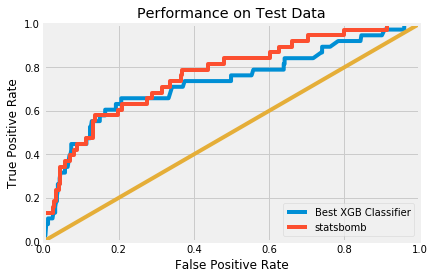

In [69]:
from sklearn.metrics import roc_auc_score
plot_roc_curve(y_test,y_test_proba,test_statsbomb,model_label='Best XGB Classifier')
plt.title('Performance on Test Data');
print('The auc score for the Best XGB model on the test data is {}'.format(round(roc_auc_score(y_test,y_test_proba[:,1]),3)))
print('The auc score for the Statsbomb model on the test data is {}'.format(round(roc_auc_score(y_test,test_statsbomb),2)))

In [70]:
dump(best_xgb,'best_xgb.joblib')

['best_xgb.joblib']

Analyze feature importance for the above models

In [71]:
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':12})

Loading saved models

In [72]:
best_logit = load('best_logit.joblib')
best_xgb = load('best_xgb.joblib')
best_gradboost = load('best_gradboost.joblib')

An indirect way of capturing feature importance in logistic regression is to extract the coefficients for each feature.

In [74]:
# logistic regression
logit_coefs = best_logit.coef_
logit_coefs[0]

array([ 0.22790418, -0.2278875 ,  0.06679869,  0.01650319, -0.14354737,
        0.06026218, -0.06577972,  0.00553422,  0.06026218, -0.25808969,
        0.19784419,  0.06026218, -0.03964366,  0.03966035, -0.55452555,
        0.41193534, -0.53363451])

In [75]:
# xgBoost
xgb_importances = best_xgb.feature_importances_
xgb_importances

array([0.13806978, 0.        , 0.        , 0.        , 0.0740285 ,
       0.        , 0.06234969, 0.        , 0.        , 0.14044124,
       0.07196683, 0.        , 0.        , 0.        , 0.14649402,
       0.19281025, 0.17383967], dtype=float32)

In [76]:
# Gradient Boost
gradboost_importances = best_gradboost.feature_importances_
gradboost_importances

array([0.01598014, 0.03939182, 0.        , 0.        , 0.00377562,
       0.        , 0.        , 0.        , 0.        , 0.04581719,
       0.        , 0.        , 0.        , 0.        , 0.14639601,
       0.60231174, 0.14632748])

Plotting them all together

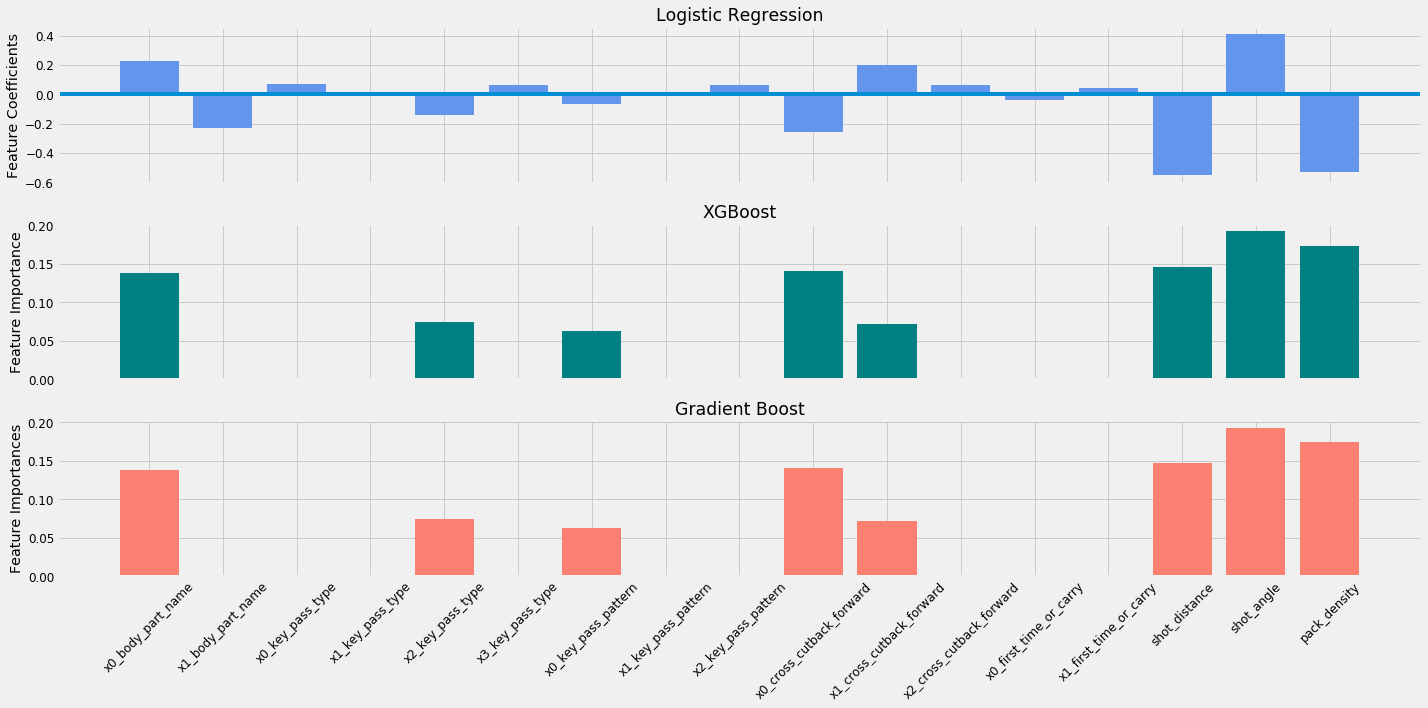

In [84]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,figsize=(20,10),sharex=True)

#logistic regression plot
ax1.bar(range(len(logit_coefs[0])),logit_coefs[0],align='center', color = 'cornflowerblue');
ax1.axhline(y=0)
ax1.set_ylabel('Feature Coefficients');
ax1.set_title('Logistic Regression')

#xgboost plot
ax2.bar(range(len(xgb_importances)),xgb_importances,align='center', color = 'teal');
ax2.set_ylabel('Feature Importance');
ax2.set_title('XGBoost')

#gradboost plot
ax3.bar(range(len(xgb_importances)),xgb_importances,align='center', color ='salmon');
ax3.set_xticks(np.arange(0,len(xgb_importances),1))
ax3.set_xticklabels(['x0_body_part_name','x1_body_part_name','x0_key_pass_type',
             'x1_key_pass_type','x2_key_pass_type','x3_key_pass_type',
            'x0_key_pass_pattern','x1_key_pass_pattern','x2_key_pass_pattern',
            'x0_cross_cutback_forward','x1_cross_cutback_forward','x2_cross_cutback_forward',
            'x0_first_time_or_carry','x1_first_time_or_carry','shot_distance','shot_angle','pack_density']);
plt.xticks(rotation=45);
ax3.set_ylabel('Feature Importances');
ax3.set_title('Gradient Boost')


plt.tight_layout()

fig.savefig('feature_importance.png')


Observations:

- The most important features are unsurprisingly the shot distance, shot angle and pack density. This makes intuitive sense
- The most important categorical features seem to be the body part used to take the shot, what type of pass preceded the shot and whether it was taken first time. This also makes sense when considering the statistical inference and data exploration results
- XGBoost and Gradient Boost do not consider some of the varieties within each categorical variable important, while Logistic regression gives small coefficients to most of these values
- Of the features considered, the pattern of play which resulted in the key pass and the pass direction are considered least important